# CLUSTERING 
Autor: Diego Zapata Alcaraz

diego080495@gmail.com

### IMPORTAMOS LIBRERÍAS

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer
#import umap
import umap.umap_ as umap
import umap.plot as umap_plot
from tqdm import tqdm

from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs

### LECTURA DE LOS DATOS

In [107]:
data, true_labels = make_blobs(n_samples=500, n_features=8, centers=5, 
                               random_state=8, cluster_std=5)

col_feacture = ["feactare_"+str(i) for i in range(0,data.shape[1])]
data = pd.DataFrame(data, columns=col_feacture)

data["feactare_cat"] = np.where(data.sum(axis=1) < 0, "Rojo",
                    np.where(data.sum(axis=1) <= 8, "Azul", "Verde"))

data.head()

,feactare_0,feactare_1,feactare_2,feactare_3,feactare_4,feactare_5,feactare_6,feactare_7,feactare_cat
0,0.061774,10.324755,9.439204,-2.942120,-5.134456,-11.574159,2.380161,-3.654791,Rojo
1,2.418185,-6.020835,-7.644391,4.307332,-2.107318,2.273280,0.976314,-3.078751,Rojo
2,-3.741057,2.179957,6.806274,-3.641872,-4.076847,5.151278,-15.784896,0.165362,Rojo
3,-10.070902,-13.327818,4.695502,7.473644,-0.775388,2.721577,-18.007457,-7.265353,Rojo
4,5.688322,9.683088,7.751649,-0.505843,3.810267,-3.751229,-10.103082,1.806576,Verde


### CLUSTERIZACIÓN

In [108]:
#Preprocesando los datos numéricos
numerical = data.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1,1))

#Preprocesando los datos categóricos
categorical = data.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

# #El porcentaje de la columnas que son categóricas es usado como factor de peso en el algoritmo
categorical_weight = len(data.select_dtypes(include='object').columns) / data.shape[1]

#Embedding numerical and categorical
fit1 = umap.UMAP(metric = 'l2').fit(numerical)
fit2 = umap.UMAP(metric = 'dice').fit(categorical)

gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable


In [109]:
categorical_weight

0.1111111111111111

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Axes: >

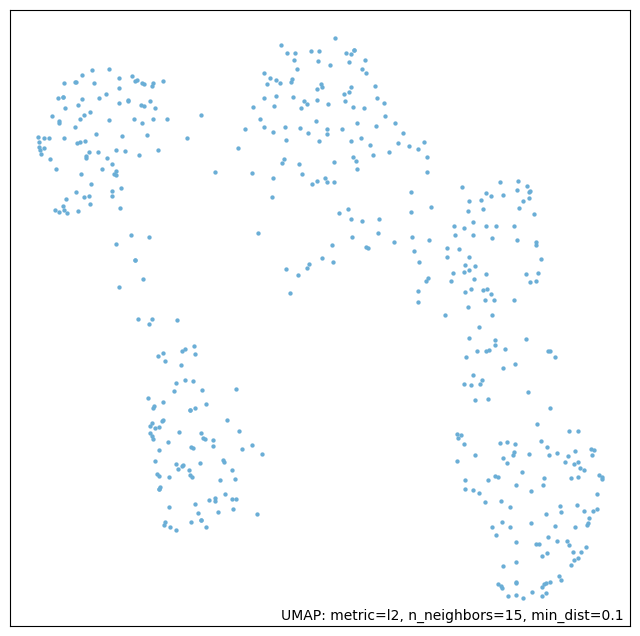

In [110]:
umap_plot.points(fit1)

<Axes: >

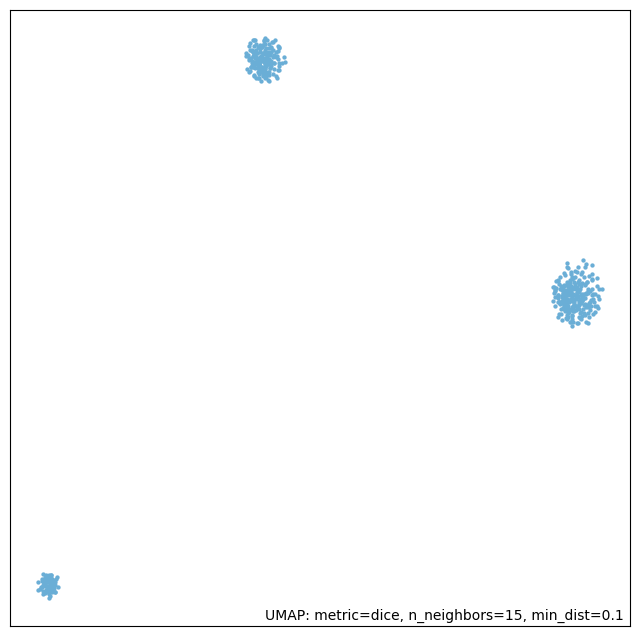

In [111]:
umap_plot.points(fit2)

In [112]:
kprot_data = data.copy()
#Pre-processing
for c in data.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

for c in data.select_dtypes(include='object').columns:
    pt = PowerTransformer() 
    kprot_data[c] =  kprot_data[c].astype("category")

kprot_data = np.array(kprot_data)
categorical_columns = [8] #make sure to specify correct indices

In [113]:
costs = []
n_clusters = []
clusters_assigned = []

for i in tqdm(range(2,12)):
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=0)
        clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)
        costs.append(kproto.cost_)
        # kproto = KMeans(n_clusters=i)
        # clusters = kproto.fit_transform(kprot_data)
        # costs.append(kproto.inertia_)
        n_clusters.append(i)
        # clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:01<00:00,  6.15s/it]


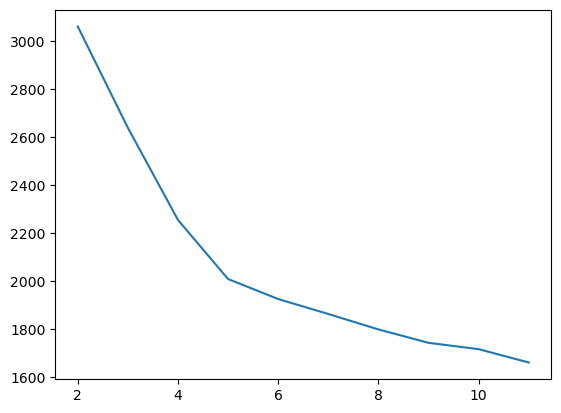

In [114]:
plt.plot(n_clusters, costs, '-')

### ENTENDIMIENTO DE LOS CLUSTER

In [115]:
#Actual clustering
kproto = KPrototypes(n_clusters=5, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

#Prints the count of each cluster group
pd.Series(clusters).value_counts()

2    111
4    103
1    100
3     94
0     92
dtype: int64

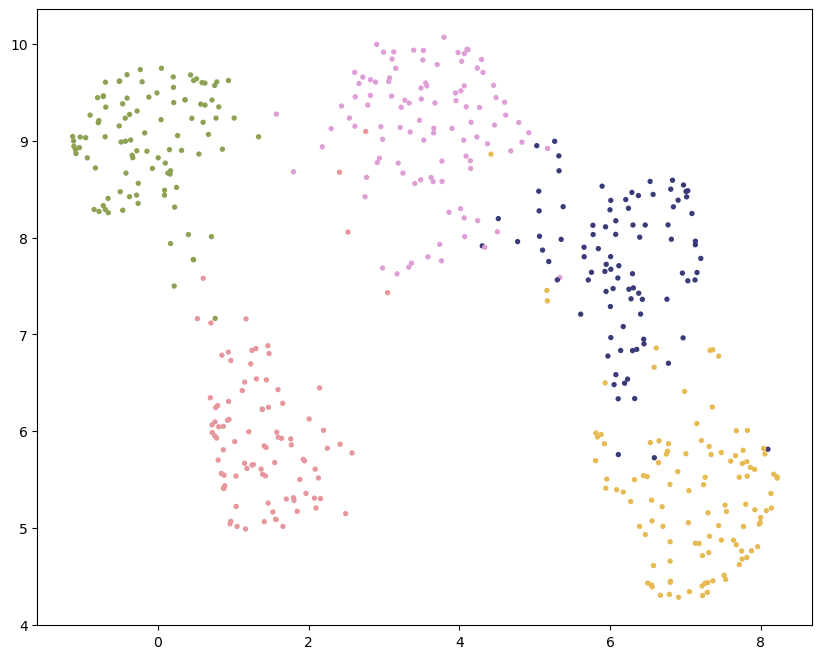

In [116]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 8))
scatter = ax.scatter(fit1.embedding_[:, 0], fit1.embedding_[:, 1], s=8, c=clusters, cmap='tab20b', alpha=1.0)

In [117]:
#Setting the objects to category 
lgbm_data = data.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

In [118]:
clf_kp = LGBMClassifier()
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, clusters, scoring='accuracy')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

CV F1 score for K-Prototypes clusters is 0.922


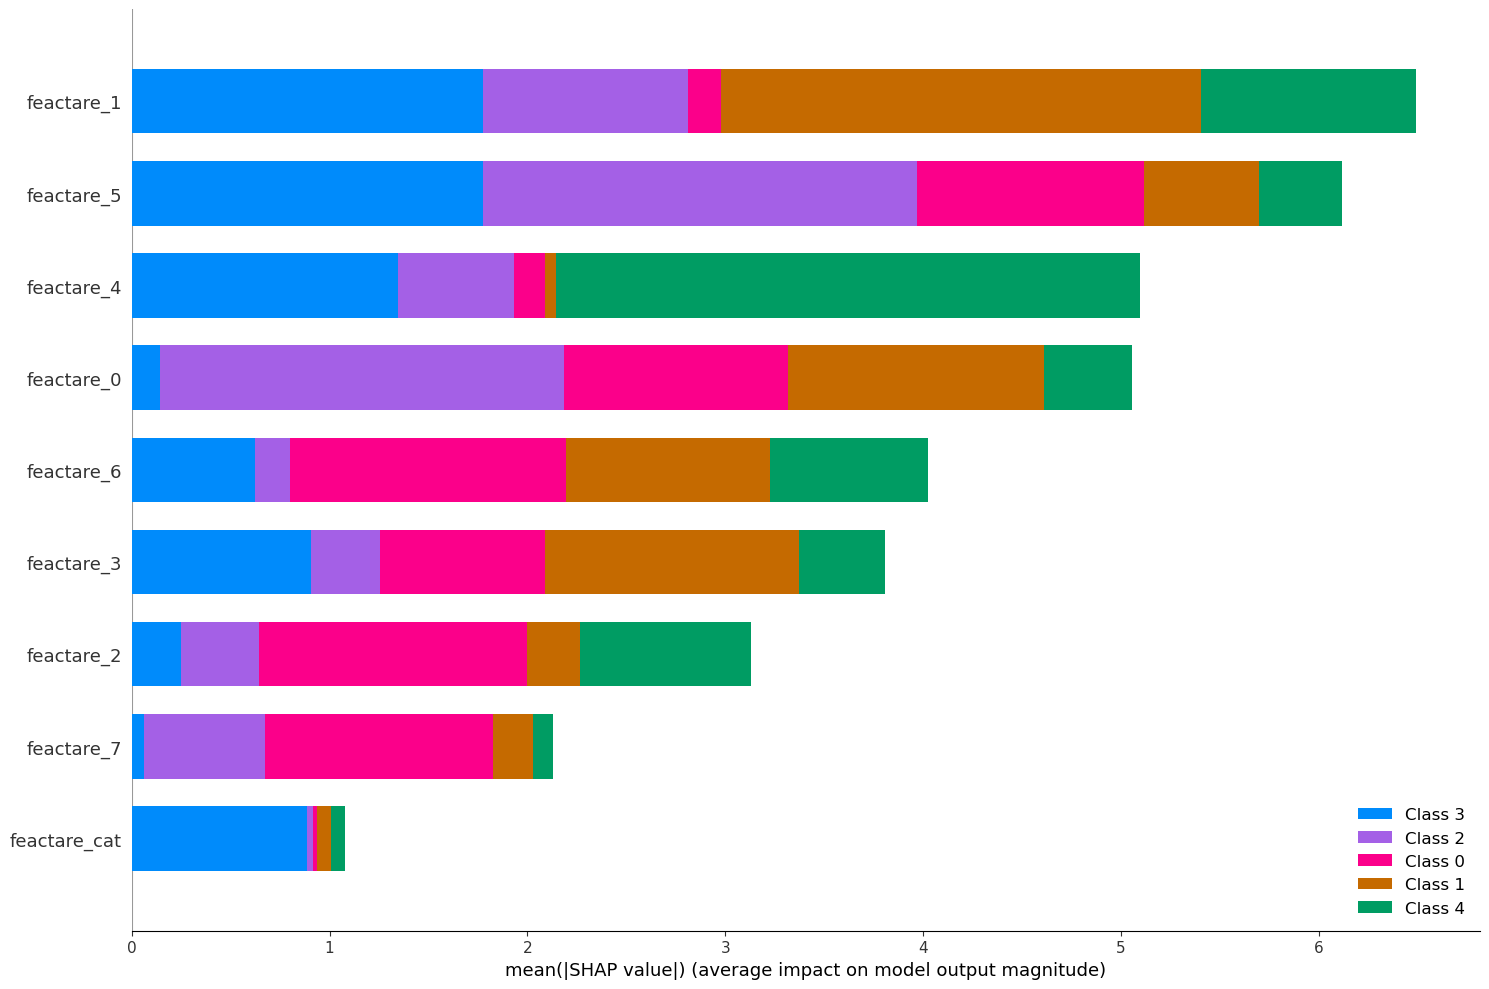

In [119]:
clf_kp.fit(lgbm_data, clusters)
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

In [120]:
data['CLUSTER'] = clusters

In [ ]:
data = data.reset_index()

In [ ]:
data.to_excel(r'Cluster data//clustering_data.xlsx', index=False)